In [1]:
import pandas, numpy
from matplotlib import pyplot
import matplotlib.pyplot as plt

Parsing the file containing the ICMP trace. 
Using only the column containing the destination address, sequence number and RTT. 
Skipping the initial header rows and final training rows containing statistics.

In [25]:
trace = pandas.read_csv('./traces/163-1.txt', 
                        delim_whitespace=True, 
                        usecols=[5,10], 
                        skiprows=[0,1], 
                        skipfooter=3, 
                        header=None, 
                        names=['seq', 'rtt'],
                        comment="ping",
                        engine='python')
print(trace[:10])

      seq     rtt
0   seq=2  20.823
1   seq=3  15.458
2   seq=4  11.053
3   seq=5  32.374
4   seq=6  17.303
5   seq=7  14.498
6   seq=8  19.863
7   seq=9  16.098
8  seq=10   9.453
9  seq=12  10.990


The ICMP packets that have timed-out are not appearing properly, so we are droping them. 

In [26]:
trace = trace.dropna()

Converting the column containing the packet sequence into an integer.

In [27]:
for index, row in trace.iterrows():
    trace.at[index, 'seq'] = int(row['seq'][4:])

Making the packet sequence the main index of the Dataframe.

In [28]:
trace.index = trace['seq']
trace = trace.drop(['seq'], axis=1)
print(trace[:10])

        rtt
seq        
2    20.823
3    15.458
4    11.053
5    32.374
6    17.303
7    14.498
8    19.863
9    16.098
10    9.453
12   10.990


Unfortunately the trace files include duplicate entries that need to be removed

In [29]:
trace = trace[~trace.index.duplicated()]

The ICMP packets that have timed-out are not included. However, the sequence numbering can be used to identify the missing values. Now we need to introduce the lost packets. We assume that the ICMP traces are for 1000 packets.

In [30]:
trace = trace.reindex(pandas.Series(range(1, 1000)))

Plotting mean RTT over time

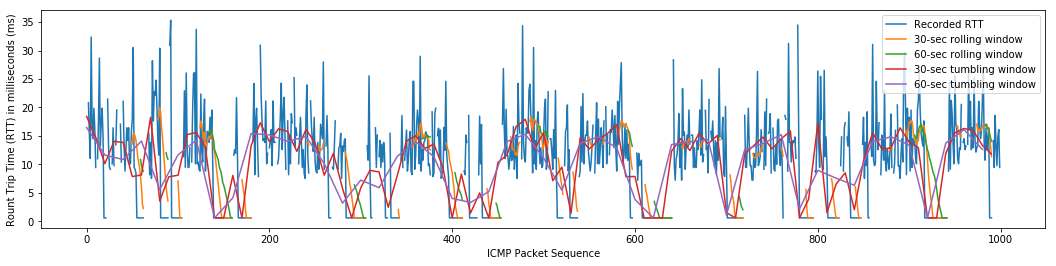

In [8]:
plt.figure(figsize=(18,4))
plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.xlabel('ICMP Packet Sequence')
plt.plot(trace['rtt'], label='Recorded RTT')
plt.plot(trace['rtt'].rolling(10).mean(), label='30-sec rolling window')
plt.plot(trace['rtt'].rolling(20).mean(), label='60-sec rolling window')
plt.plot(trace.groupby(trace.index // 10 * 10).mean(), label='30-sec tumbling window')
plt.plot(trace.groupby(trace.index // 20 * 20).mean(), label='60-sec tumbling window')
plt.legend()

Plotting number of packets recorded over time window

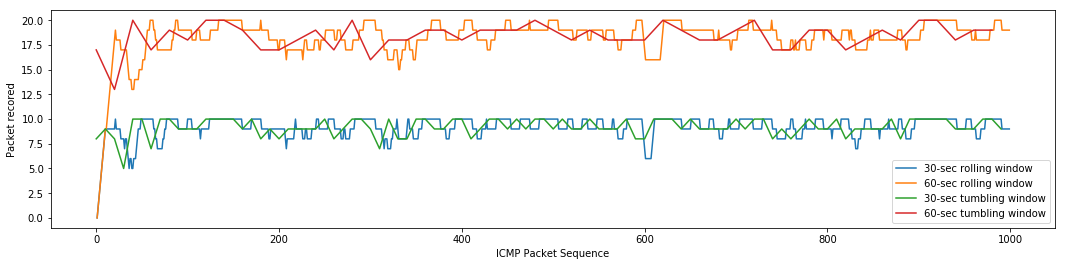

In [9]:
plt.figure(figsize=(18,4))
plt.ylabel('Packet recored')
plt.xlabel('ICMP Packet Sequence')
plt.plot(trace['rtt'].rolling(10).count(), label='30-sec rolling window')
plt.plot(trace['rtt'].rolling(20).count(), label='60-sec rolling window')
plt.plot(trace.groupby(trace.index // 10 * 10).count(), label='30-sec tumbling window')
plt.plot(trace.groupby(trace.index // 20 * 20).count(), label='60-sec tumbling window')
plt.legend()

Construct a new dataframe containing only the tumbling windows with the corresponding statistics

In [16]:
window_size = 10

Start with packet loss, make sure that column is converted to float and compute percentage based on window size.

In [47]:
stats = trace.groupby(trace.index // window_size).count()
stats = stats.rename(index=str, columns={"rtt": "packet_loss"})
stats["packet_loss"] = pandas.to_numeric(stats["packet_loss"], downcast='float')
for index, row in stats.iterrows():
    stats.at[index, 'packet_loss'] = row['packet_loss'] / window_size

Include other simple statistics for each window

In [69]:
stats = stats.assign(mean=trace.groupby(trace.index // window_size).mean()['rtt'].values)
stats = stats.assign(min=trace.groupby(trace.index // window_size).min()['rtt'].values)
stats = stats.assign(max=trace.groupby(trace.index // window_size).max()['rtt'].values)
stats = stats.assign(std=trace.groupby(trace.index // window_size).std()['rtt'].values)
stats = stats.assign(var=trace.groupby(trace.index // window_size).var()['rtt'].values)

In [70]:
stats

,packet_loss,mean,min,max,std,var
0,0.8,18.433750,11.053,32.374,6.410225,4.109098e+01
1,0.9,14.725778,0.589,28.672,7.744291,5.997404e+01
2,0.8,10.120000,0.589,21.463,7.181169,5.156919e+01
3,0.5,14.042600,9.773,19.543,4.216951,1.778268e+01
4,1.0,13.861400,8.819,21.068,3.717869,1.382255e+01
5,1.0,7.851800,0.591,30.523,9.910803,9.822401e+01
6,0.7,8.128857,0.591,18.903,7.746326,6.000556e+01
7,1.0,18.256000,7.539,28.214,6.451027,4.161575e+01
8,1.0,3.573000,0.591,30.406,9.428155,8.889011e+01
9,0.9,7.819222,0.591,35.319,14.384162,2.069041e+02


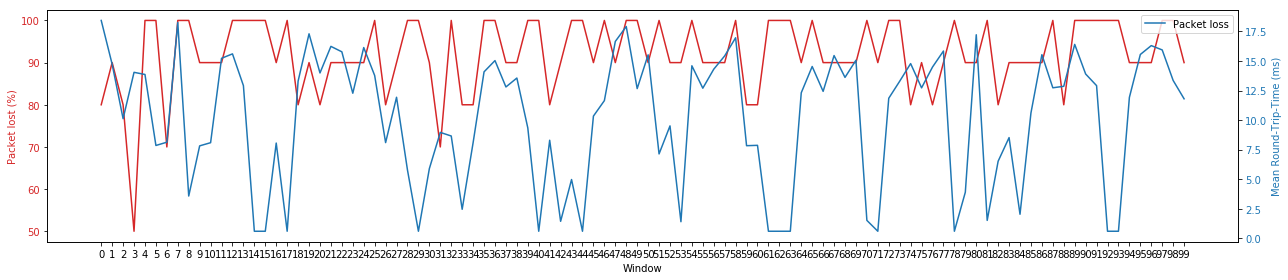

In [82]:
fig, ax1 = plt.subplots(figsize=(18,4))

color = 'tab:red'
ax1.set_xlabel('Window')
ax1.set_ylabel('Packet lost (%)', color=color)
ax1.plot(stats['packet_loss']*100, label='Packet loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mean Round-Trip-Time (ms)', color=color)  # we already handled the x-label with ax1
ax2.plot(stats['mean'], label='Packet loss', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()